In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import statsmodels.api as sm
from matplotlib_venn import venn3

**Figure 3A**

HOMER output files from "HOMER_Annotation.sh"

In [2]:
high=pd.read_csv('Figure3_data/High_knownResults.txt',sep='\t')
low=pd.read_csv('Figure3_data/Low_knownResults.txt',sep='\t')
hi=[]
lo=[]
odds=[]
p=[]
motif=[]
lower=[]
upper=[]
for x in np.union1d(low[low['q-value (Benjamini)']<.05]['Motif Name'],high[high['q-value (Benjamini)']<.05]['Motif Name']):
    h=high[high['Motif Name']==x]
    l=low[low['Motif Name']==x]
    a=h.iloc[0]['# of Target Sequences with Motif(of 1858)']
    b=l.iloc[0]['# of Target Sequences with Motif(of 2374)']
    c=1858-a
    d=2374-b
    odd,pv=stats.fisher_exact([[a,b], [c,d]])
    lower_ci,upper_ci=sm.stats.Table2x2(np.asarray([[a,b],[c,d]])).oddsratio_confint(alpha=0.05, method='normal')
    odds.append(odd)
    p.append(pv)
    motif.append(x)
    lower.append(lower_ci)
    upper.append(upper_ci)
df=pd.DataFrame(np.vstack((odds,p,motif,upper,lower)).T,columns=['OR','P','Motif','Upper','Lower'])
x=df[df.P.astype(float)<=(.05/len(motif))].sort_values(by='OR',ascending=True)
x.Motif=[y.split('(')[0] for y in x.Motif]

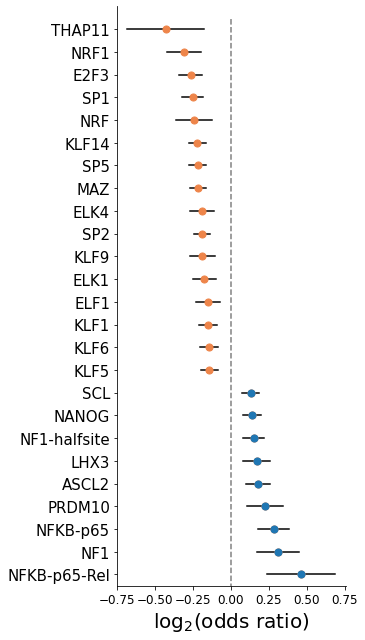

In [3]:
df=pd.DataFrame(np.vstack((odds,p,motif,upper,lower)).T,columns=['OR','P','Motif','Upper','Lower'])
x=df[df.P.astype(float)<=(.05/len(motif))].sort_values(by='OR',ascending=False)
x.Motif=[y.split('(')[0] for y in x.Motif]
plt.figure(figsize=(5,9))
for a,b,c in zip(x.Upper.astype(float),x.Lower.astype(float),x.Motif):
    plt.plot([np.log10(a),np.log10(b)],[c,c],'k',zorder=1)
plt.scatter(np.log10(x.OR.astype(float)),x.Motif,color=sns.color_palette('muted')[1],marker='o',s=50,zorder=2)
plt.scatter(np.log10(x[x.OR.astype(float)>1].OR.astype(float)),x[x.OR.astype(float)>1].Motif,color=sns.color_palette()[0],marker='o',s=50,zorder=2)

sns.despine()
plt.plot([0,0],[-1,x.Motif.shape[0]-0.5],'--',color='gray')
plt.ylim([-.5,x.Motif.shape[0]])
plt.xlabel('log$_{2}$(odds ratio)',fontsize=20)
order=['THAP11','NRF1','E2F3','SP1','NRF','KLF14','SP5','MAZ','ELK4','SP2','KLF9','ELK1','ELF1','KLF1','KLF6','KLF5','SCL','NANOG','NF1-halfsite','LHX3','ASCL2','PRDM10','NFKB-p65','NF1','NFKB-p65-Rel']
plt.xticks(fontsize=12)
plt.yticks(np.arange(len(order)),order[::-1],fontsize=15)
plt.tight_layout()
plt.savefig('Panels/Figure3A.pdf',transparent=True,dpi=500)
plt.show()
plt.close()

**Figure 3B**

In [4]:
#Import Kallisto abundance files (pt{name}_abundance.tsv) and Sleuth results table
df=pd.read_csv('common_data/Sleuth_results_all.txt')
df=df.sort_values(by='qval')
df=df[df.ens_gene.astype(str)!='nan']
df_abundance=pd.read_pickle('common_data/Kallisto_abundance.pkl')

In [5]:
motifs=['THAP11','NRF1','E2F3','SP1','NRF','KLF14','SP5','MAZ','ELK4','SP2','KLF9','ELK1','ELF1','KLF1',
    'KLF6','KLF5','TAL1','NANOG','NF1','LHX3','ASCL2','PRDM10','NFKB1','NFKB2','NF1']
s=['pt214_lo_tpm','pt221_lo_tpm','pt226_lo_tpm','pt214_hi_tpm','pt221_hi_tpm','pt226_hi_tpm']

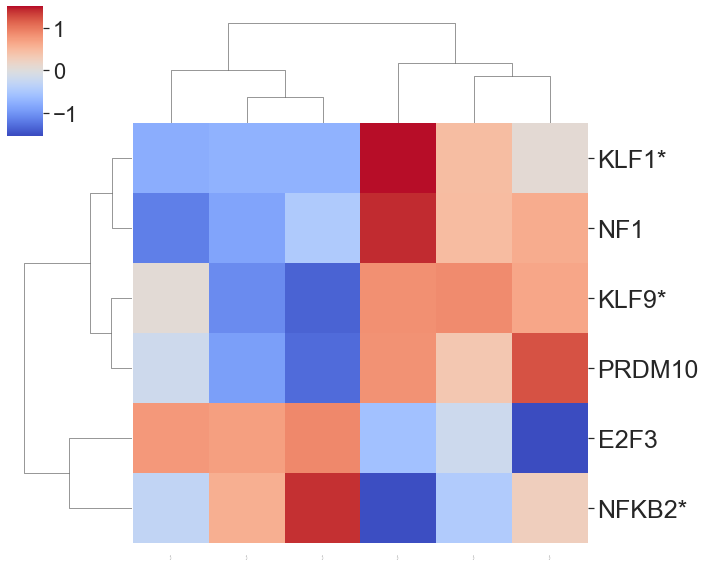

In [6]:
t=[]
g=[]
b=[]
for gene in motifs:
    x=df[df.ext_gene==gene]
    x=x[x.qval<0.05]
    t=np.hstack((t,x.target_id))
    g=np.hstack((g,x.ext_gene))
    b=np.hstack((b,x.b))
x=df_abundance.loc[t]
x.index=np.array(g)
x.index=[x+'*' if x in ['KLF1','KLF9','NFKB2'] else x for x in x.index]
x=x.drop_duplicates()
sns.set(font_scale=2)
cm=sns.clustermap(np.log2(x[s]+0.1),robust=True,col_cluster=1,
               cmap='coolwarm',z_score=0,center=0)
cm.ax_heatmap.set_xticklabels(cm.ax_heatmap.get_xmajorticklabels(), fontsize = 0)
cm.ax_heatmap.set_yticklabels(cm.ax_heatmap.get_ymajorticklabels(), fontsize = 25,rotation=0)
plt.savefig('Panels/Figure3B.pdf',transparent=True,dpi=500)
plt.show()
plt.close()

**Figure 3C-D**

In [7]:
df_all=pd.read_pickle('common_data/fivepseq_abundance_tsr.pkl')
df_High=df_all[(df_all.High>1) & (df_all.Low==0)]
df_Low=df_all[(df_all.Low>1) & (df_all.High==0)]
df_High[['Chr','Start','Stop','UniqueIdentifier']].to_csv('Figure3_data/High_hg38.txt',header=None,index=False,sep='\t')
df_Low[['Chr','Start','Stop','UniqueIdentifier']].to_csv('Figure3_data/Low_hg38.txt',header=None,index=False,sep='\t')
#UCSC genome liftover hg38 -> hg19 to be compatibile w/ SEdb
high=pd.read_csv('Figure3_data/High_hg19.txt',sep='\t',header=None)
low=pd.read_csv('Figure3_data/Low_hg19.txt',sep='\t',header=None)
high.columns=['chr','start','stop','index']
low.columns=['chr','start','stop','index']

In [8]:
SE=pd.read_csv('Figure3_data/SE_package.txt',sep='\t')
SE=SE[['chr','start','end']]
SE=SE.drop_duplicates()

In [9]:
#Calculate distance between TSR and SE
for it,df in enumerate([high,low]):
    distance=[]
    direction=[]
    index=[]
    for chromosome in df.chr.unique():
        if chromosome in SE.chr.unique():
            se_chr=SE[SE.chr==chromosome].sort_values(by='start')
            df_chr=df[df.chr==chromosome]
            for i in range(df_chr.shape[0]):
                row=df_chr.iloc[i]
                try:
                    upstream=np.array(se_chr.start-row.stop)
                    upstream=min(upstream[upstream>0])
                    downstream=row.start-se_chr.end
                    downstream=min(downstream[downstream>0])
                    closest=min(upstream,downstream)
                    distance.append(closest)
                    direction.append(upstream<downstream)
                    index.append(row['index'])
                except:
                    pass
    direction=np.array([-1 if x==True else 1 for x in direction])
    distance=np.array(distance)
    if it==0:
        dir_distance_high=pd.DataFrame(np.vstack((direction*distance,['High']*distance.shape[0],index)).T)
    else:
        dir_distance_low=pd.DataFrame(np.vstack((direction*distance,['Low']*distance.shape[0],index)).T)
df=dir_distance_high.append(dir_distance_low)
df.columns=['Distance','Class','Index']
df.Distance=df.Distance.astype(int)
df.Distance=df.Distance/1000
df['Direction']=['Upstream' if np.sign(x)==1 else 'Downstream' for x in df.Distance]
df=df.assign(Abs_distance=df.Distance.abs())
df_SE=df

In [10]:
TE=pd.read_csv('Figure3_data/TE_package.txt',sep='\t',header=None)
TE=TE[TE.columns[:3]]
TE.columns=['chr','start','end']
TE=TE.drop_duplicates()

In [11]:
#Calculate distance between TSR and TE
for it,df in enumerate([high,low]):
    distance=[]
    direction=[]
    index=[]
    for chromosome in df.chr.unique():
        if chromosome in TE.chr.unique():
            se_chr=TE[TE.chr==chromosome].sort_values(by='start')
            df_chr=df[df.chr==chromosome]
            for i in range(df_chr.shape[0]):
                row=df_chr.iloc[i]
                try:
                    upstream=np.array(se_chr.start-row.stop)
                    upstream=min(upstream[upstream>0])
                    downstream=row.start-se_chr.end
                    downstream=min(downstream[downstream>0])
                    closest=min(upstream,downstream)
                    distance.append(closest)
                    direction.append(upstream<downstream)
                    index.append(row['index'])
                except:
                    pass
    direction=np.array([-1 if x==True else 1 for x in direction])
    distance=np.array(distance)
    if it==0:
        dir_distance_high=pd.DataFrame(np.vstack((direction*distance,['High']*distance.shape[0],index)).T)
    else:
        dir_distance_low=pd.DataFrame(np.vstack((direction*distance,['Low']*distance.shape[0],index)).T)
df=dir_distance_high.append(dir_distance_low)
df.columns=['Distance','Class','Index']
df.Distance=df.Distance.astype(int)
df.Distance=df.Distance/1000
df['Direction']=['Upstream' if np.sign(x)==1 else 'Downstream' for x in df.Distance]
df=df.assign(Abs_distance=df.Distance.abs())
df_TE=df

In [12]:
df_TE['Type']=['TE']*df_TE.shape[0]
df_SE['Type']=['SE']*df_SE.shape[0]
df=df_SE.append(df_TE)

MannwhitneyuResult(statistic=2002464.5, pvalue=1.78809018551608e-06)


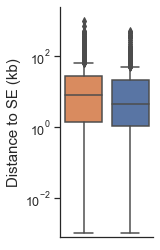

In [13]:
sns.set_style("white")
sns.set_style("ticks")
plt.figure(figsize=(2.75,4))
sns.boxplot(x='Class',y='Abs_distance',data=df[df.Type=='SE'],order=['Low','High'],palette=[sns.color_palette('muted')[1],sns.color_palette()[0]])
sns.despine()
print(stats.mannwhitneyu(df[(df.Type=='SE') & (df.Class=='High')].Abs_distance,df[(df.Type=='SE') & (df.Class=='Low')].Abs_distance))
plt.xlabel('')
plt.xticks([])
plt.ylim([.0008,2500])
plt.yscale('log')
plt.yticks(fontsize=12.5)
plt.ylabel('Distance to SE (kb)',fontsize=15)
plt.tight_layout()
plt.savefig('Panels/Figure3C.pdf',transparent=True,dpi=500)
plt.show()
plt.close()

MannwhitneyuResult(statistic=2380165.5, pvalue=1.870814111830171e-06)


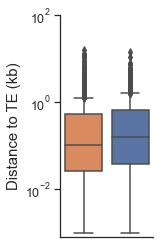

In [14]:
sns.set_style("white")
sns.set_style("ticks")
plt.figure(figsize=(2.75,4))
sns.boxplot(x='Class',y='Abs_distance',data=df[df.Type=='TE'],order=['Low','High'],palette=[sns.color_palette('muted')[1],sns.color_palette()[0]])
sns.despine()
print(stats.mannwhitneyu(df[(df.Type=='TE') & (df.Class=='High')].Abs_distance,df[(df.Type=='TE') & (df.Class=='Low')].Abs_distance))
plt.xlabel('')
plt.xticks([])
plt.ylim([.0008,100])
plt.yscale('log')
plt.yticks(fontsize=12.5)
plt.ylabel('Distance to TE (kb)',fontsize=15)
plt.tight_layout()
plt.savefig('Panels/Figure3D.pdf',transparent=True,dpi=500)
plt.show()
plt.close()

**Figure 3E**

In [15]:
tpm_lo=['pt212_lo_TPM','pt221_lo_TPM','pt226_lo_TPM','pt87_lo_TPM','pt214_lo_TPM']
tpm_hi=['pt212_hi_TPM','pt221_hi_TPM','pt226_hi_TPM','pt87_hi_TPM','pt214_hi_TPM']
tpm=np.hstack((tpm_hi,tpm_lo))

Ttest_relResult(statistic=5.175682948689765, pvalue=0.0066259842053060436)


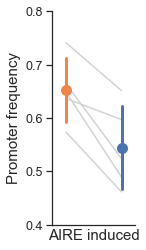

Ttest_relResult(statistic=-0.07972021149674276, pvalue=0.9414798651489442)


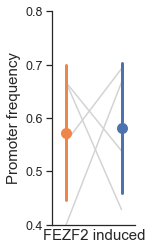

Ttest_relResult(statistic=11.09249838127094, pvalue=0.0003757180100445931)


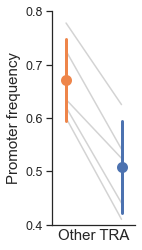

Ttest_relResult(statistic=5.825616832662318, pvalue=0.004324621331431714)


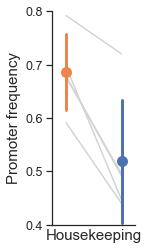

In [16]:
for j in np.arange(4):
    df=df_High.append(df_Low)
    if j==0: 
        df=df[(df.Fezf2_dep==False) & (df.Aire_dep==True)]
        xlabel='AIRE induced'
    elif j==1: 
        df=df[(df.Fezf2_dep==True) & (df.Aire_dep==False)]
        xlabel='FEZF2 induced'
    elif j==2: 
        df=df[(df.Other_TRA==True)]
        xlabel='Other TRA'
    elif j==3: 
        df=df[(df.Housekeeping==True)]
        xlabel='Housekeeping'
    masked_df=1*(df[tpm]>0)
    i=0
    for feature in ['Annotations_short']:
        for name in tpm:
            if df[masked_df[name]==1].shape[0]>3:
                percentage=np.sum(df[masked_df[name]==1][feature]=='promoter-TSS')/df[masked_df[name]==1].shape[0]
                x=pd.DataFrame(np.vstack((feature,percentage,name.split('_')[0],name.split('_')[1])).T,columns=['Feature','Percentage','Patient','Hue'])
                if i==0:
                    y=x
                else:
                    y=y.append(x)
                i+=1
    y.Percentage=y.Percentage.astype(float)
    plt.figure(figsize=(2.5,4))
    feature='Annotations_short'
    for x in y.Patient.unique():
        plt.plot([0.5,0.1],[y[(y.Feature==feature) & (y.Patient==x) & (y.Hue=='hi')].Percentage,y[(y.Feature==feature) & (y.Patient==x) & (y.Hue=='lo')].Percentage],color='lightgray',zorder=1)

    plt.scatter(0.5,y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.mean(),lw=5,zorder=3)
    plt.plot([0.5,0.5],[y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.mean()+y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.std(),
                   y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.mean()-y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.std()],lw=3,zorder=2)

    plt.scatter(.1,y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.mean(),lw=5,zorder=3,color=sns.color_palette('muted')[1])
    plt.plot([.1,.1],[y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.mean()+y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.std(),
                    y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.mean()-y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.std()],lw=3,zorder=2, color=sns.color_palette('muted')[1])

    print(stats.ttest_rel(y[(y.Feature==feature) & (y.Hue=='lo')].Percentage,y[(y.Feature==feature) & (y.Hue=='hi')].Percentage))

    plt.xlim([0,.6])
    plt.ylim([.4,.8])
    plt.xticks([])
    plt.yticks(fontsize=12.5)
    plt.xlabel('')
    #plt.xlabel(fontsize=0)
    plt.ylabel('Promoter frequency',fontsize=15)
    plt.xlabel(xlabel,fontsize=15)
    sns.despine() 
    plt.tight_layout()
    plt.savefig('Panels/Figure3E_'+str(j+1)+'.pdf',transparent=True,dpi=500)
    plt.show()
    plt.close()         

**Figure 3F**

In [17]:
df=pd.read_csv('common_data/Sleuth_results_all.txt')
df=df.sort_values(by='qval')
df=df[df.ens_gene.astype(str)!='nan']
df_abundance=pd.read_pickle('common_data/Kallisto_abundance.pkl')
aire=df_abundance.loc[df[df.ens_gene.isin(df_all[df_all.Aire_dep==True].Nearest_Ensembl)].target_id]
fezf2=df_abundance.loc[df[df.ens_gene.isin(df_all[df_all.Fezf2_dep==True].Nearest_Ensembl)].target_id]

MannwhitneyuResult(statistic=6228390.5, pvalue=4.620165221965914e-06)


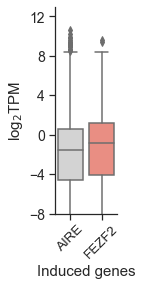

In [18]:
plt.figure(figsize=(2.25,4.5))
sns.set_style("ticks")
x=pd.DataFrame(np.vstack((fezf2[['pt214_hi_tpm','pt221_hi_tpm','pt226_hi_tpm']].mean(axis=1),
           ['Fezf2']*fezf2.shape[0])).T)
x=x.append(pd.DataFrame(np.vstack((aire[['pt214_hi_tpm','pt221_hi_tpm','pt226_hi_tpm']].mean(axis=1),
           ['Aire']*aire.shape[0])).T))
x.columns=['value','category']
x.value=x.value.astype(float)
print(stats.mannwhitneyu(x[x.category=='Fezf2'].value,x[x.category=='Aire'].value))
x.value=np.log2(x.value+0.000001)
sns.boxplot(x='category',y='value',data=x,palette=['lightgray','salmon'],order=['Aire','Fezf2'])
plt.ylim([-8,13])
plt.yticks(np.arange(-8,14,4),fontsize=14)
plt.xticks([0,1],['AIRE','FEZF2'],fontsize=13.5,rotation=45)
plt.xlabel('Induced genes',fontsize=15)
plt.ylabel('log$_2$TPM',fontsize=15)
sns.despine() 
plt.tight_layout()
plt.savefig('Panels/Figure3F.pdf',transparent=True,dpi=500)
plt.show()
plt.close()

**Figure 3G**

ngs.plot.r -G mm10 -R tss 